# In this notebook I explore the LLR dependence in galaxy scaling relations

In [197]:
import seaborn as sns
from astropy.io import fits
from multiprocessing import Pool
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import Table
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']= 3
plt.rcParams['xtick.major.size'] =8
plt.rcParams['ytick.major.size'] =8
plt.rcParams['xtick.minor.size'] =4
plt.rcParams['ytick.minor.size'] =4
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['font.size'] =25
plt.rcParams['figure.figsize'] = (12,12)

In [69]:
def load_datasets(orig=True):

    if orig:
        TNG50 = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG50_Rot_blobsLike_orig_0.03_0.055.csv')[['objid','likelihood','galsky','skysig','LLR']]
        TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike_orig_0.03_0.055.csv')
        Illustris = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/Illustris_Rot_blobsLike_orig_0.03_0.055.csv')[['objid','likelihood','LLR']]
        
        TNG50_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG50_ordered_Mgt9.5_skysub_orig.csv',sep=' ')[['objid','mag','sersic_n_r','flag_r', 'sersic_rhalf_r',\
                                                                                                                    'StellarMasses_in_r30pkpc','SFR_MsunPerYrs_in_all_10Myrs']]
        TNG_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG_ordered_Mgt9.5_skysub_orig.csv',sep=' ')[['objid','mag']]
        Illustris_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_ill_ordered_Mgt9.5_skysub_orig.csv',sep=' ')#[['objid','mag']]
        
        TNG50 = TNG50.merge(TNG50_mag, on='objid')
        TNG = TNG.merge(TNG_mag, on='objid')
        Illustris = Illustris.merge(Illustris_mag, on='objid')      
        
    else:
        TNG50 = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG50_Rot_blobsLike_orig_0.03_0.055_magmatch.csv')
        TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike_orig_0.03_0.055_magmatch.csv')
        Illustris = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/Illustris_Rot_blobsLike_orig_0.03_0.055_magmatch.csv')
        
        TNG_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG_ordered_Mgt9.5_skysub_magmatch.csv',sep=' ')[['objid','mag']]
        TNG50_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG50_ordered_Mgt9.5_skysub_magmatch.csv',sep=' ')[['objid','mag']]
        TNG50 = TNG50.merge(TNG50_mag, on='objid')
        TNG = TNG.merge(TNG_mag, on='objid')      
        
    TNG50_mhalo = pd.read_csv('/scratch/lzanisi/pixel-cnn/TNG50_cutouts/TNG50_mhalo.csv')
    TNG50 = TNG50.merge(TNG50_mhalo, on='objid')
    TNG50 = TNG50.rename(columns={'galsky':'sky [nmaggie]','flag_r':'flag_sersic','mag_x':'mag','StellarMasses_in_r30pkpc':'Mstar', 'SFR_MsunPerYrs_in_all_10Myrs':'SFR'})

    SDSS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.03_0.055_blobsLike_skysub.dat',sep=' ')[35000:]#[['objid','galcount','','LCentSat','mag']]
    SDSS_all = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_Rot_blobsLike_0.03_0.055_all.csv')[['galcount','likelihood','LLR']]
    #SDSS_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.03_0.055_blobsLike_skysub_onlymag.dat', sep= ' ')
    
    SDSS = SDSS.merge(SDSS_all, on='galcount')
    #SDSS = SDSS.query('MhaloL>0').sample(frac=9196/len(SDSS_all))
    #SDSS = SDSS_L.merge(SDSS, on='galcount')
    
    # add physical properties to TNG
    df_f = pd.read_csv('/scratch/lzanisi/pixel-cnn/TNG_cutouts/snap_95_unfiltered_bis.csv')[['Unnamed: 0','SFR']]
    TNG = pd.merge(TNG, df_f, left_on='Illustris_ID_2_2', right_on='Unnamed: 0')
    mhalo = pd.read_csv('/scratch/lzanisi/pixel-cnn/TNG_cutouts/snap_95_mhalomean.csv')[['Unnamed: 0', 'ParentDM']]
    TNG = pd.merge(TNG, mhalo, left_on='Illustris_ID_2_2', right_on='Unnamed: 0')
    centrals_jstar = pd.read_csv('/scratch/lzanisi/pixel-cnn/TNG_cutouts/TNG_jstar_s95_lzanisi.csv') #this contains only centrals
    TNG = pd.merge(TNG, centrals_jstar, left_on = 'Illustris_ID_2_2', right_on='Illustris_ID_2_1', how='outer' )
    TNG['LCentSat'] = TNG['sJ_star_1re'].apply(lambda x: 0 if x!=x else 1)
    TNG['SFR'] = TNG['SFR'].apply(lambda x: np.log10(x) if x==x else np.nan)
    TNG50['SFR'] = TNG50['SFR'].apply(lambda x: np.log10(x) if x==x else np.nan)

    #clean
    TNG = TNG.query('likelihood>3000 & sersic_n>0 & LLR>-50 & sersic_n<7  & LLR<500')
    TNG50 = TNG50.query('likelihood>3000 & sersic_n_r>0 & LLR>-50 & sersic_n_r<7  & LLR<500')

    Illustris = Illustris.query('likelihood>3000 & sersic_n>0 & LLR>-50  &  sersic_n<7 & LLR<500')
    SDSS = SDSS.query('likelihood>3000  & LLR>-50  & LLR<500 & GalSky_err>0 ')
    
    #rename
    SDSS['sky [nmaggie]'] = SDSS['GalSky'].apply(lambda x: 10**(-0.4*(x-22.5)  )*0.396**2)
    Illustris = Illustris.rename(columns={'galsky':'sky [nmaggie]'})
    TNG = TNG.rename(columns={'sky':'sky [nmaggie]','mag_x':'mag','LogMass30':'Mstar','ParentDM':'Mhalo'}) 
    TNG50 = TNG50.rename(columns={'galsky':'sky [nmaggie]','mag_x':'mag','StellarMasses_in_r30pkpc':'Mstar', 'SFR_MsunPerYrs_in_all_10Myrs':'SFR'})
    SDSS = SDSS.rename(columns={'MsMendSerExp':'Mstar','MhaloL':'Mhalo'})
    
    
    TNG['$logR_e \ [arcsec]$'] = TNG['sersic_rhalf'].apply(lambda x: np.log10(0.396*x))
    TNG['$n_{ser}$'] = TNG['sersic_n'].copy()
    TNG['sSFR'] = TNG.apply(lambda row: row.SFR-row.Mstar,axis=1)
    TNG['sSFR'] = TNG['sSFR'].apply(lambda x: -12.5 if x<-12.5 or x!=x else x)
    
    TNG50['$logR_e \ [arcsec]$'] = TNG50['sersic_rhalf_r'].apply(lambda x: np.log10(0.396*x))
    TNG50['$n_{ser}$'] = TNG50['sersic_n_r'].copy()
    TNG50['sSFR'] = TNG50.apply(lambda row: row.SFR-row.Mstar,axis=1)
    TNG50['sSFR'] = TNG50['sSFR'].apply(lambda x: -12.5 if x<-12.5 or x!=x else x)
    
    Illustris['$logR_e \ [arcsec]$'] = Illustris['sersic_rhalf'].apply(lambda x: np.log10(0.396*x))
    Illustris['$n_{ser}$'] = Illustris['sersic_n'].copy()
    Illustris['sSFR'] = Illustris.apply(lambda row: row.SFR-row.Mstar,axis=1)
    Illustris['sSFR'] = Illustris['sSFR'].apply(lambda x: -12.5 if x<-12.5 or x!=x else x)
    
    SDSS['$logR_e \ [arcsec]$'] = SDSS['r_bulge'].apply(np.log10)
    SDSS = SDSS[SDSS['$logR_e \ [arcsec]$']>-1]
    SDSS['$n_{ser}$'] = SDSS['n_bulge'].copy()
    SDSS['sSFR'] = SDSS.apply(lambda row: row.SFR-row.Mstar,axis=1)
    SDSS['sSFR'] = SDSS['sSFR'].apply(lambda x: -12.5 if x<-12.5 or x!=x else x)
    
    
    
    return SDSS, TNG50, TNG, Illustris

In [70]:
SDSS, TNG50, TNG, Illustris = load_datasets(orig=True)

/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
SDSS_cen = SDSS.query('LCentSat==1')
TNG_cen = TNG.query('LCentSat==1')
TNG50_cen = TNG50.query('LCentSat==1')
Illustris_cen = Illustris.query('LCentSat==1')

SDSS_sat = SDSS.query('LCentSat==2')
TNG_sat = TNG.query('LCentSat==0')
TNG50_sat = TNG50.query('LCentSat==0')
Illustris_sat = Illustris.query('LCentSat==0')

# Re-Mstar

### Exploration

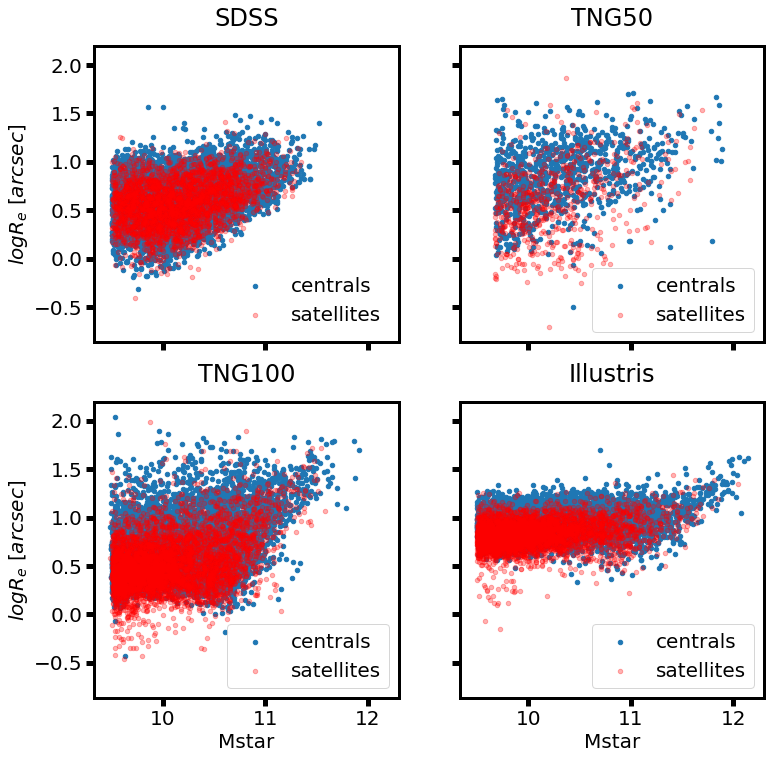

In [72]:
dsets = [SDSS_cen,TNG50_cen,TNG_cen,Illustris_cen]
titles = ['SDSS','TNG50','TNG100','Illustris']
fig,ax = plt.subplots(2,2, sharex=True, sharey=True)
for dset,(a,tit) in zip(dsets, zip(ax.ravel(),titles)):
    dset.plot.scatter('Mstar','$logR_e \ [arcsec]$', ax=a, label='centrals')
    a.set_title(tit)
dsets = [SDSS_sat,TNG50_sat,TNG_sat,Illustris_sat]
for dset,a in zip(dsets, ax.ravel()):
    dset.plot.scatter('Mstar','$logR_e \ [arcsec]$', ax=a, color='red',alpha=0.3, label='satellites')
ax[0][0].legend(frameon=False)

### Plot for all galaxies

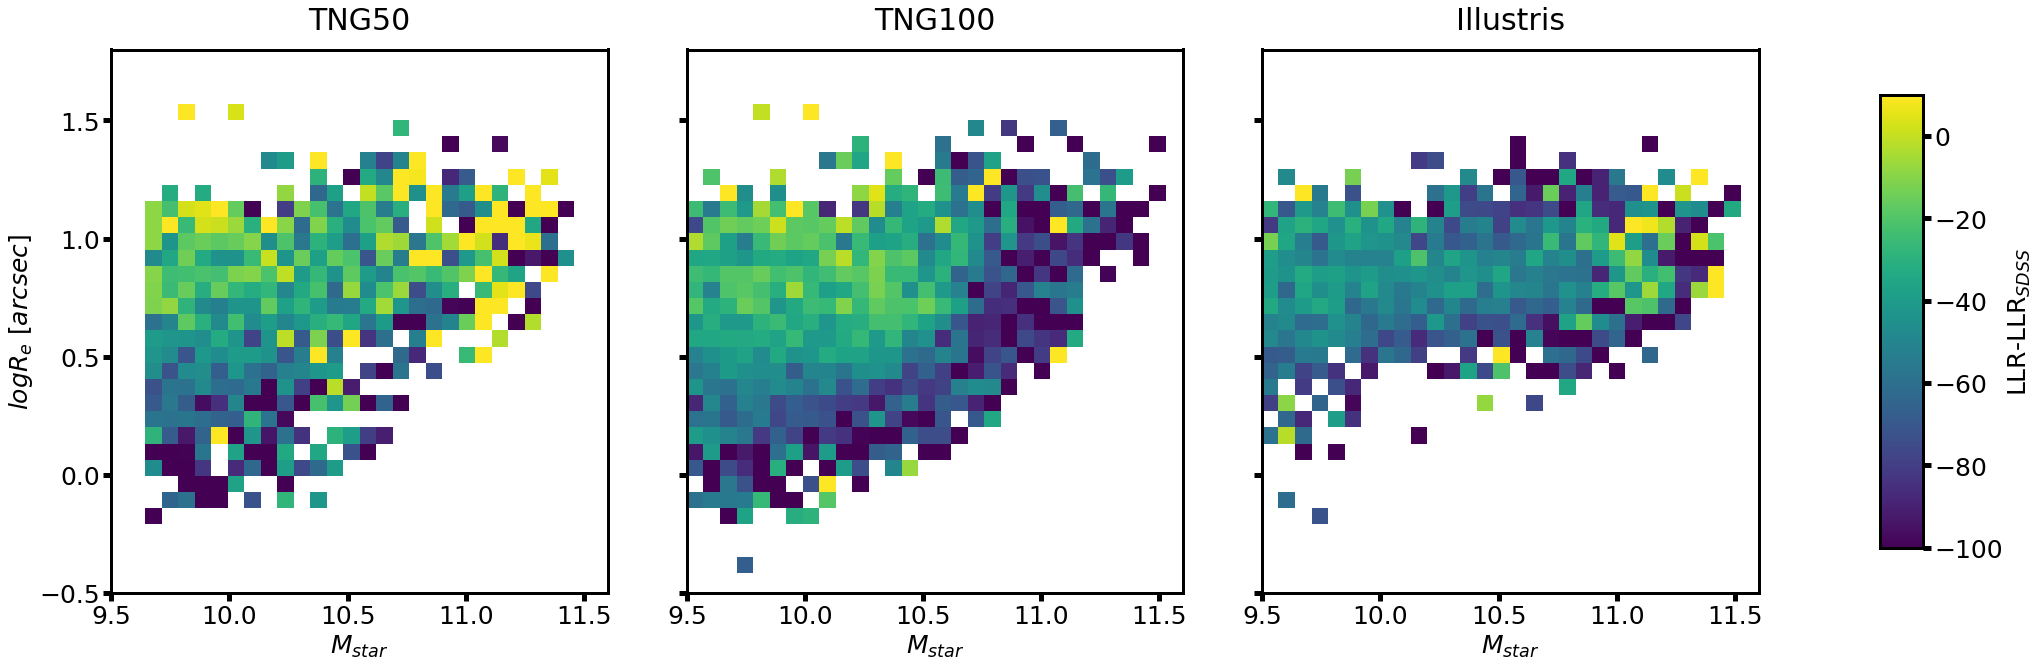

In [200]:
binsx = np.linspace(SDSS['Mstar'].min(), SDSS['Mstar'].max(),30)
binsy = np.linspace(SDSS['$logR_e \ [arcsec]$'].min(), SDSS['$logR_e \ [arcsec]$'].max(),30)

stat_SDSS, x,y,_ = binned_statistic_2d(SDSS['Mstar'],SDSS['$logR_e \ [arcsec]$'], values=SDSS['LLR'], statistic='mean',bins=[binsx,binsy])

dsets = [TNG50,TNG,Illustris]
titles = ['TNG50','TNG100','Illustris']
plt.rcParams['figure.figsize'] = (30,10)
fig,ax_ = plt.subplots(1,3,  sharey=True)

for dset,(a,tit) in zip(dsets, zip(ax_.ravel(),titles)):
    stat_dset, x,y,_ = binned_statistic_2d(dset['Mstar'],dset['$logR_e \ [arcsec]$'], values=dset['LLR'],statistic='mean',bins=[binsx,binsy])
    delta = np.flipud(stat_dset.T)-np.flipud(stat_SDSS.T)
 
 
    im=a.imshow(delta, extent=(x[0],x[-1],y[0],y[-1] ), vmin=-100,vmax=10)
    a.set_xlim(9.5,11.6)
    a.set_ylim(-0.5,1.8)
    #m = plt.cm.ScalarMappable(cmap=cm.viridis)
    #m.set_array(delta)
    #m.set_clim(-200., 0.)
    #plt.colorbar(m, boundaries=np.linspace(-200, 0, 10))
    #dset.plot.scatter('Mstar','$logR_e \ [arcsec]$', ax=a, alpha=0.1)
    
    a.set_title(tit)
    a.set_xlabel('$M_{star}$')
ax_[0].set_ylabel('$logR_e \ [arcsec]$')
fig.subplots_adjust(wspace=0.1,hspace=0)
# put colorbar at desire position

cax = fig.add_axes([ax[-1].get_position().x1+0.05,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('LLR-LLR$_{SDSS}$')


### plot for centrals

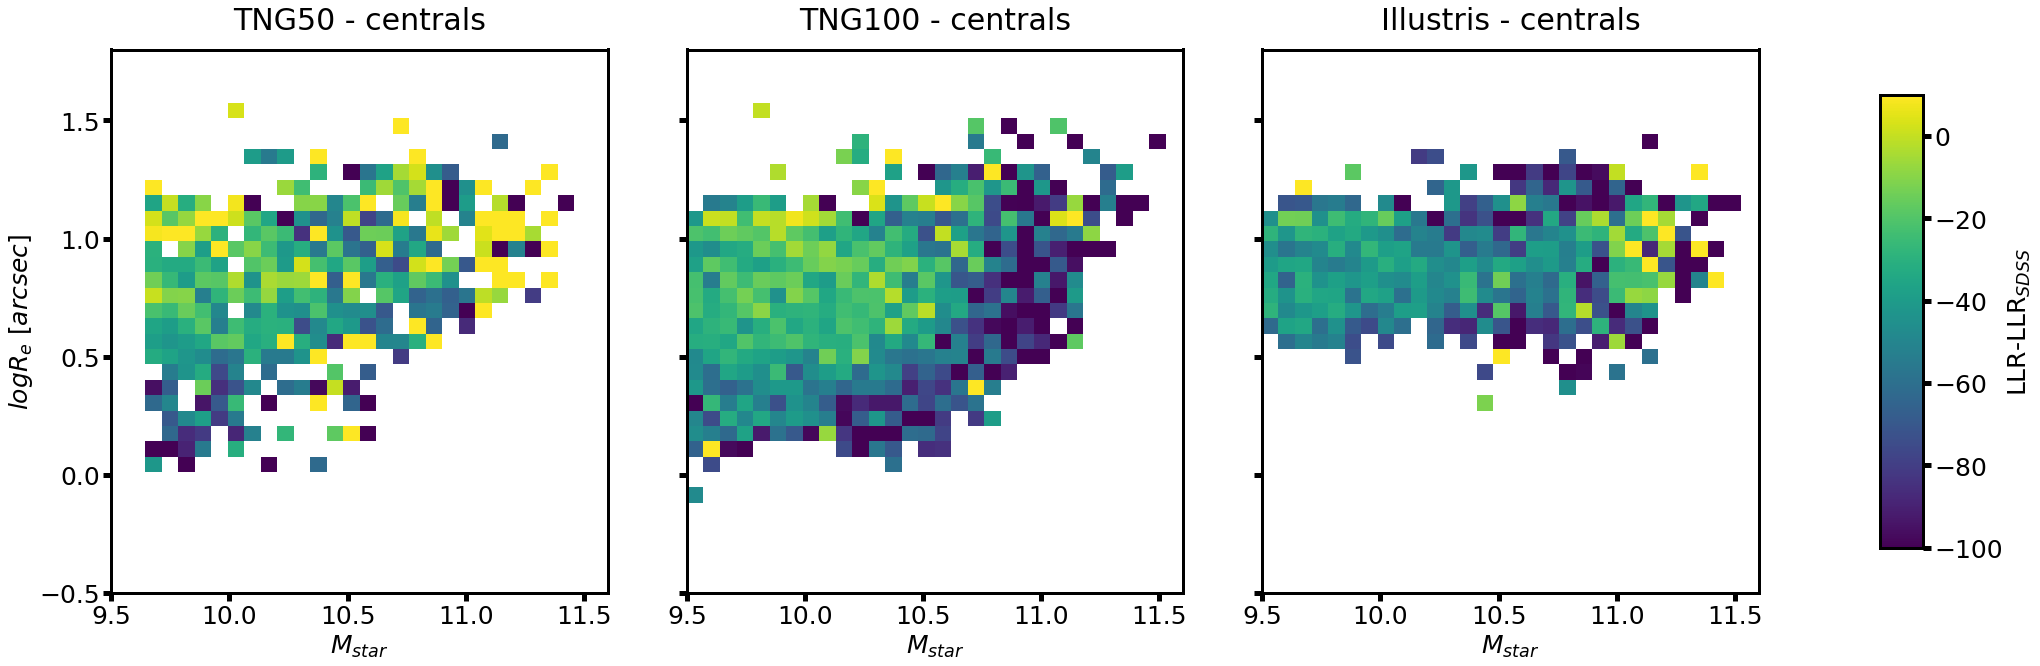

In [201]:
binsx = np.linspace(SDSS_cen['Mstar'].min(), SDSS_cen['Mstar'].max(),30)
binsy = np.linspace(SDSS_cen['$logR_e \ [arcsec]$'].min(), SDSS_cen['$logR_e \ [arcsec]$'].max(),30)

stat_SDSS, x,y,_ = binned_statistic_2d(SDSS_cen['Mstar'],SDSS_cen['$logR_e \ [arcsec]$'], values=SDSS_cen['LLR'], statistic='mean',bins=[binsx,binsy])

dsets = [TNG50_cen,TNG_cen,Illustris_cen]
titles = ['TNG50 - centrals','TNG100 - centrals','Illustris - centrals']
plt.rcParams['figure.figsize'] = (30,10)
fig,ax_ = plt.subplots(1,3,  sharey=True)

for dset,(a,tit) in zip(dsets, zip(ax_.ravel(),titles)):
    stat_dset, x,y,_ = binned_statistic_2d(dset['Mstar'],dset['$logR_e \ [arcsec]$'], values=dset['LLR'],statistic='mean',bins=[binsx,binsy])
    delta = np.flipud(stat_dset.T)-np.flipud(stat_SDSS.T)
 
 
    im=a.imshow(delta, extent=(x[0],x[-1],y[0],y[-1] ), vmin=-100,vmax=10)
    a.set_xlim(9.5,11.6)
    a.set_ylim(-0.5,1.8)
    #m = plt.cm.ScalarMappable(cmap=cm.viridis)
    #m.set_array(delta)
    #m.set_clim(-200., 0.)
    #plt.colorbar(m, boundaries=np.linspace(-200, 0, 10))
    #dset.plot.scatter('Mstar','$logR_e \ [arcsec]$', ax=a, alpha=0.1)
    
    a.set_title(tit)
    a.set_xlabel('$M_{star}$')
ax_[0].set_ylabel('$logR_e \ [arcsec]$')
fig.subplots_adjust(wspace=0.1,hspace=0)
# put colorbar at desire position

cax = fig.add_axes([ax[-1].get_position().x1+0.05,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('LLR-LLR$_{SDSS}$')

### plot for satellites

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


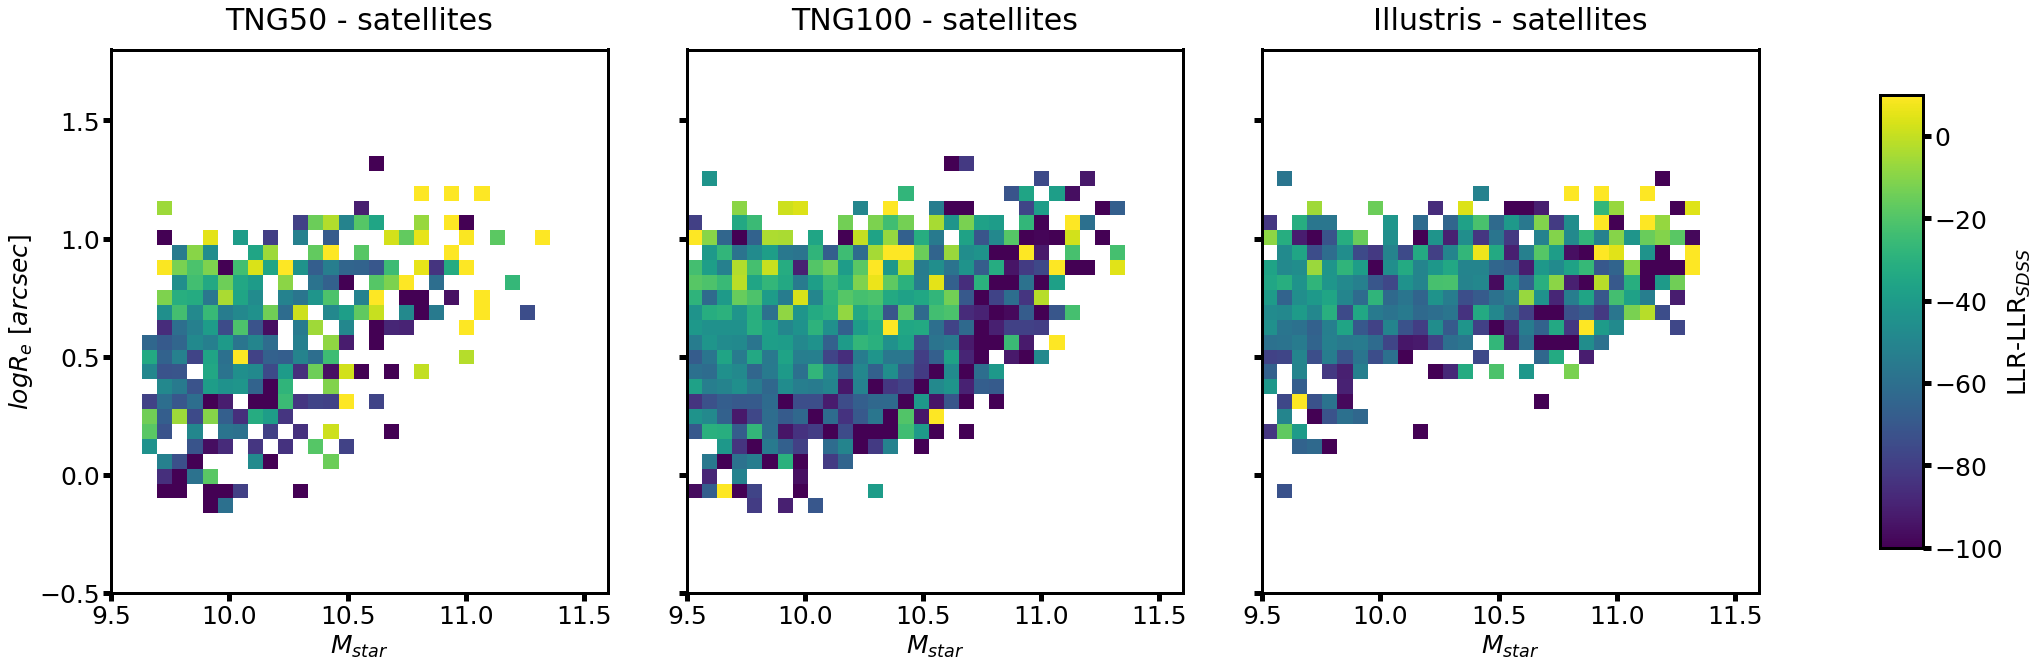

In [202]:
binsx = np.linspace(SDSS_sat['Mstar'].min(), SDSS_sat['Mstar'].max(),30)
binsy = np.linspace(SDSS_sat['$logR_e \ [arcsec]$'].min(), SDSS_sat['$logR_e \ [arcsec]$'].max(),30)

stat_SDSS, x,y,_ = binned_statistic_2d(SDSS_sat['Mstar'],SDSS_sat['$logR_e \ [arcsec]$'], values=SDSS_sat['LLR'], statistic='mean',bins=[binsx,binsy])

dsets = [TNG50_sat,TNG_sat,Illustris_sat]
titles = ['TNG50 - satellites','TNG100 - satellites','Illustris - satellites']
plt.rcParams['figure.figsize'] = (30,10)
fig,ax_ = plt.subplots(1,3,  sharey=True)

for dset,(a,tit) in zip(dsets, zip(ax_.ravel(),titles)):
    stat_dset, x,y,_ = binned_statistic_2d(dset['Mstar'],dset['$logR_e \ [arcsec]$'], values=dset['LLR'],statistic='mean',bins=[binsx,binsy])
    delta = np.flipud(stat_dset.T)-np.flipud(stat_SDSS.T)
 
 
    im=a.imshow(delta, extent=(x[0],x[-1],y[0],y[-1] ), vmin=-100,vmax=10)
    a.set_xlim(9.5,11.6)
    a.set_ylim(-0.5,1.8)
    #m = plt.cm.ScalarMappable(cmap=cm.viridis)
    #m.set_array(delta)
    #m.set_clim(-200., 0.)
    #plt.colorbar(m, boundaries=np.linspace(-200, 0, 10))
    #dset.plot.scatter('Mstar','$logR_e \ [arcsec]$', ax=a, alpha=0.1)
    
    a.set_title(tit)
    a.set_xlabel('$M_{star}$')
ax_[0].set_ylabel('$logR_e \ [arcsec]$')
fig.subplots_adjust(wspace=0.1,hspace=0)
# put colorbar at desire position

cax = fig.add_axes([ax[-1].get_position().x1+0.05,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('LLR-LLR$_{SDSS}$')

### Main sequence

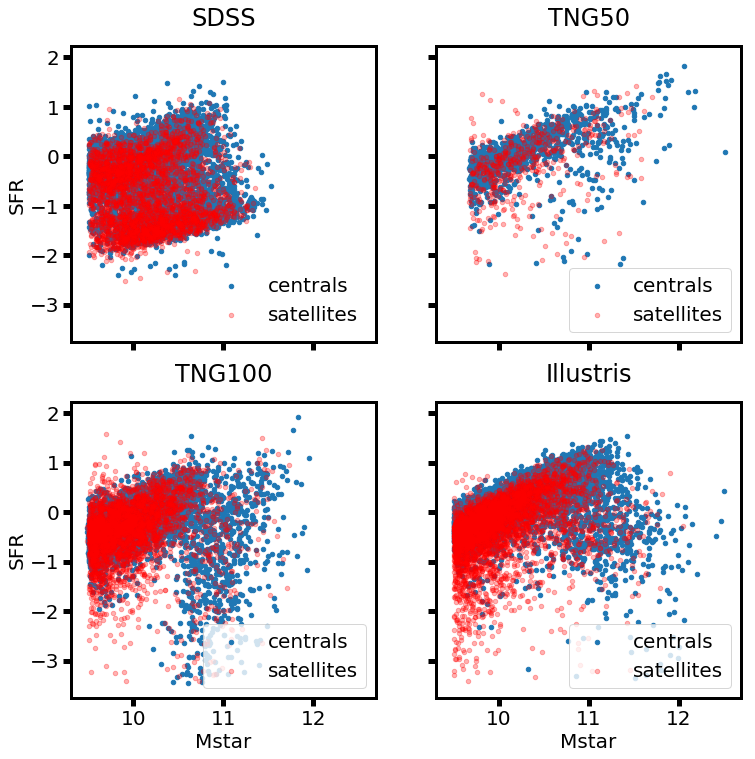

In [41]:
dsets = [SDSS_cen,TNG50_cen,TNG_cen,Illustris_cen]
fig,ax = plt.subplots(2,2, sharex=True, sharey=True)
titles = ['SDSS','TNG50','TNG100','Illustris']

for dset,(a,tit) in zip(dsets, zip(ax.ravel(),titles)):
    dset.plot.scatter('Mstar','SFR', ax=a, label='centrals')
    a.set_title(tit)

dsets = [SDSS_sat,TNG50_sat,TNG_sat,Illustris_sat]
for dset,a in zip(dsets, ax.ravel()):
    dset.plot.scatter('Mstar','SFR', ax=a, color='red',alpha=0.3, label='satellites')
ax[0][0].legend(frameon=False)

### SMHM relation

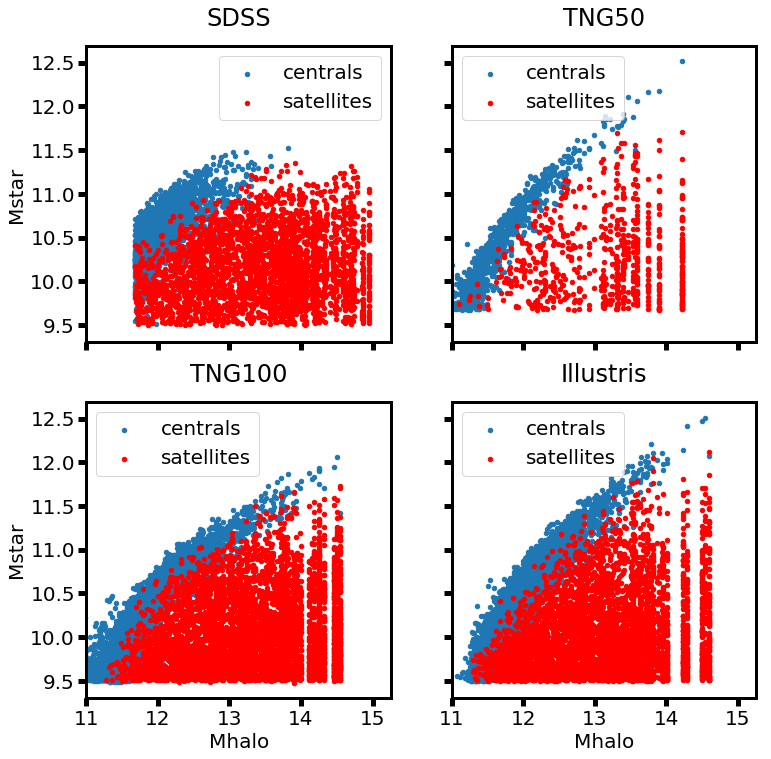

In [40]:
SDSS_cen_cut = SDSS_cen.query('Mhalo>0')
SDSS_sat_cut = SDSS_sat.query('Mhalo>0')

dsets = [SDSS_cen_cut,TNG50_cen,TNG_cen,Illustris_cen]
fig,ax = plt.subplots(2,2, sharex=True, sharey=True)
titles = ['SDSS','TNG50','TNG100','Illustris']

for dset,(a,tit) in zip(dsets, zip(ax.ravel(),titles)):
    dset.plot.scatter('Mhalo','Mstar', ax=a, label='centrals')
    a.set_title(tit)
    
dsets = [SDSS_sat_cut,TNG50_sat,TNG_sat,Illustris_sat]
for dset,a in zip(dsets, ax.ravel()):
    dset.plot.scatter('Mhalo','Mstar', ax=a, label='satellites', color='red')
    a.set_xlim(11)

# Centrals only

In [17]:
16000*0.32

5120.0